# Lending Club Loan Default Prediction

Created by Cindy Liu on 10/20/2018

Predict default loan. Binary Classification problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
location='/../Desktop/DS501/LendingClub/lc_cleaned_data.csv'
df=pd.read_csv(location)
df.shape

(277140, 46)

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277140 entries, 0 to 277139
Data columns (total 46 columns):
loan_amnt                              277140 non-null float64
int_rate                               277140 non-null float64
loan_status                            277140 non-null int64
purpose                                277140 non-null int64
delinq_2yrs                            277140 non-null float64
inq_last_6mths                         277140 non-null float64
open_acc                               277140 non-null float64
pub_rec                                277140 non-null float64
revol_bal                              277140 non-null float64
revol_util                             277140 non-null float64
total_acc                              277140 non-null float64
acc_now_delinq                         277140 non-null float64
tot_coll_amt                           277140 non-null float64
tot_cur_bal                            277140 non-null float64
total_rev_h

## Label: Loan Status

**0** for bad loan: 'Charged Off', 'Default', 'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)'  
**1** for good loan: 'Fully Paid'

In [178]:
df['loan_status'].value_counts()

0    209711
1     67429
Name: loan_status, dtype: int64

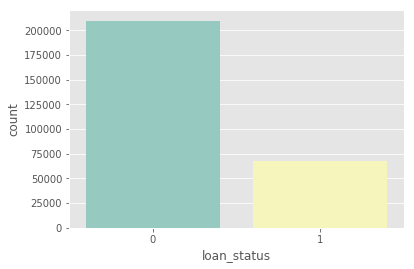

In [222]:
sns.countplot(x='loan_status',data=df,palette='Set3')
plt.show()

In [29]:
#### Select a subset of features
#select=['loan_amnt','term','int_rate','grade','home_ownership','verification_status','pymnt_plan',\
#        'open_acc','total_acc','tot_cur_bal','dti_2','annual_inc_2','addr_state_2','purpose_2','credit_history']
# select only cols w/o missing vals -- needs improvement
#non_NA = [i for i in df if len(df[i])-df[i].count()==0]
#train_sub=df[non_NA]
#train_sub.drop(['purpose','addr_state','issue_d','sub_grade'],axis=1,inplace=True)

In [4]:
X=df.drop('loan_status',axis=1)
y=df['loan_status']

## Train test split, 5-fold cv for training set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
k_fold = KFold(5,random_state=0)

# Baseline - Logistic Regression w/ default threshold

In [193]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print result.summary2()

Optimization terminated successfully.
         Current function value: 0.508667
         Iterations 6
                                   Results: Logit
Model:                    Logit                  No. Iterations:         6.0000     
Dependent Variable:       loan_status            Pseudo R-squared:       0.083      
Date:                     2018-10-31 13:33       AIC:                    197450.7049
No. Observations:         193998                 BIC:                    197908.6070
Df Model:                 44                     Log-Likelihood:         -98680.    
Df Residuals:             193953                 LL-Null:                -1.0767e+05
Converged:                1.0000                 Scale:                  1.0000     
------------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------

In [261]:
#check deviance, AIC

#### Function for calculating performance metrics for the models

In [8]:
def perf_metrics(y_train, p_train_pred, y_test, p_test_pred, threshold=0.5):
    
    names=['AUC','Accuracy','Precision','Recall','f1-score']
    
    training_metrics = [roc_auc_score(y_train,p_train_pred),
                        accuracy_score(y_train,p_train_pred>threshold),
                        precision_score(y_train, p_train_pred>threshold),
                        recall_score(y_train, p_train_pred>threshold),
                        f1_score(y_train, p_train_pred>threshold)]
    
    test_metrics = [roc_auc_score(y_test, p_test_pred),
                    accuracy_score(y_test, p_test_pred>threshold),
                    precision_score(y_test, p_test_pred>threshold),
                    recall_score(y_test, p_test_pred>threshold),
                    f1_score(y_test, p_test_pred>threshold)]
    
    all_metrics = pd.DataFrame({'metrics':names,
                                'train':training_metrics,
                                'test':test_metrics},columns=['metrics','train','test']).set_index('metrics')
    
    print all_metrics

#### Function for plotting the ROC curve for the models

In [9]:
def plot_roc(y_train, p_train_pred, y_test, p_test_pred):
    
    train_auc = roc_auc_score(y_train,p_train_pred)
    test_auc = roc_auc_score(y_test, p_test_pred)
    
    fpr_train, tpr_train, thresh_train = roc_curve(y_train,p_train_pred)
    fpr_test, tpr_test, thresh_test = roc_curve(y_test,p_test_pred)
    
    plt.figure()
    lw=2
    plt.plot(fpr_train, tpr_train, color='green', lw=lw,
             label='Train ROC (AUC=%0.4f)' % train_auc)
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=lw,
             label='Test ROC (AUC=%0.4f)' % test_auc)
    plt.plot([0,1],[0,1], color='purple', lw=lw, ls='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc='lower right')
    plt.show()

#### Function for getting indexed confusion matrix

In [10]:
def get_cm(y,p):
    cm = confusion_matrix(y,p,labels=[0,1])
    return pd.DataFrame(cm,columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])

# Regularized Logistic Regression - L2 Penalty

In [208]:
classifier = LogisticRegression(C=1.0, penalty='l2', solver='saga', random_state=0)
classifier.fit(X_train, y_train)

# Make prediction on the training data
y_train_pred = classifier.predict(X_train)
p_train_pred = classifier.predict_proba(X_train)[:,1]

# Make predictions on test data
y_test_pred = classifier.predict(X_test)
p_test_pred = classifier.predict_proba(X_test)[:,1]

In [210]:
get_cm(y_test,y_test_pred)

,pred_0,pred_1
true_0,60878,2057
true_1,17643,2564


In [227]:
perf_metrics(y_train, p_train_pred, y_test, p_test_pred, threshold=0.5)

              train      test
metrics                      
AUC        0.708473  0.707758
Accuracy   0.764931  0.763056
Precision  0.575464  0.554858
Recall     0.130723  0.126887
f1-score   0.213049  0.206541


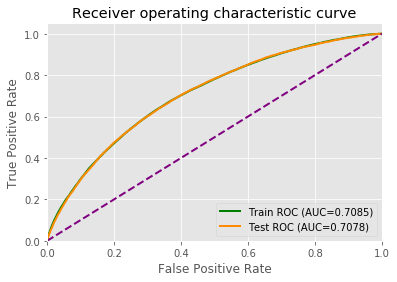

In [223]:
plot_roc(y_train, p_train_pred, y_test, p_test_pred)

### Understanding the estimated coefficients

In [230]:
df_coefs = pd.DataFrame(list(zip(df.columns, classifier.coef_.flatten()))).sort_values(by=[1],ascending=False)
df_coefs.columns = ['feature', 'coef']
df_coefs.head(10)

,feature,coef
23,grade_F,1.301086
22,grade_E,1.199460
21,grade_D,1.103236
40,verification_status_Verified,1.069978
20,grade_C,0.963642
19,grade_B,0.750549
34,emp_length_< 1 year,0.460053
18,term_ 60 months,0.427945
17,credit_history,0.366227
0,loan_amnt,0.216654


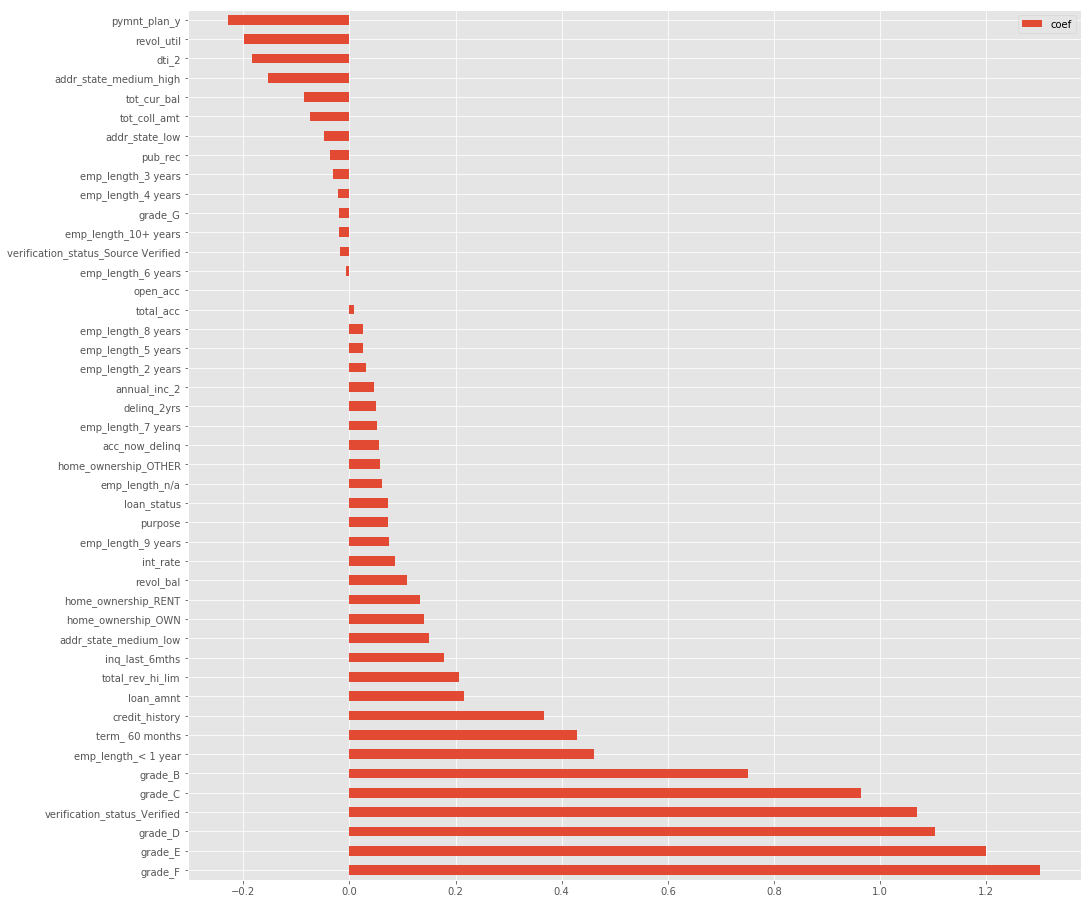

In [237]:
ax = df_coefs.plot.barh(figsize=(16,16)) 
ax.set_yticklabels(df_coefs['feature'])
plt.show()

# Regularized Logistic Regression - L1 Penalty

In [238]:
classifier = LogisticRegression(C=1.0, penalty='l1', solver='saga', random_state=0)
classifier.fit(X_train, y_train)

# Make prediction on the training data
y_train_pred = classifier.predict(X_train)
p_train_pred = classifier.predict_proba(X_train)[:,1]

# Make predictions on test data
y_test_pred = classifier.predict(X_test)
p_test_pred = classifier.predict_proba(X_test)[:,1]

In [239]:
get_cm(y_test,y_test_pred)

,pred_0,pred_1
true_0,60881,2054
true_1,17642,2565


In [240]:
perf_metrics(y_train, p_train_pred, y_test, p_test_pred, threshold=0.5)

              train      test
metrics                      
AUC        0.708475  0.707762
Accuracy   0.764915  0.763104
Precision  0.575289  0.555315
Recall     0.130744  0.126936
f1-score   0.213066  0.206638


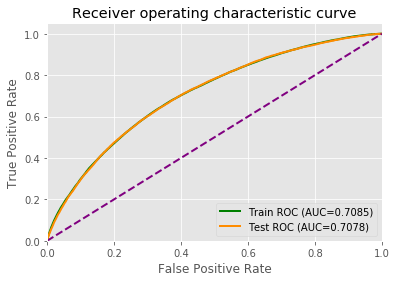

In [241]:
plot_roc(y_train, p_train_pred, y_test, p_test_pred)

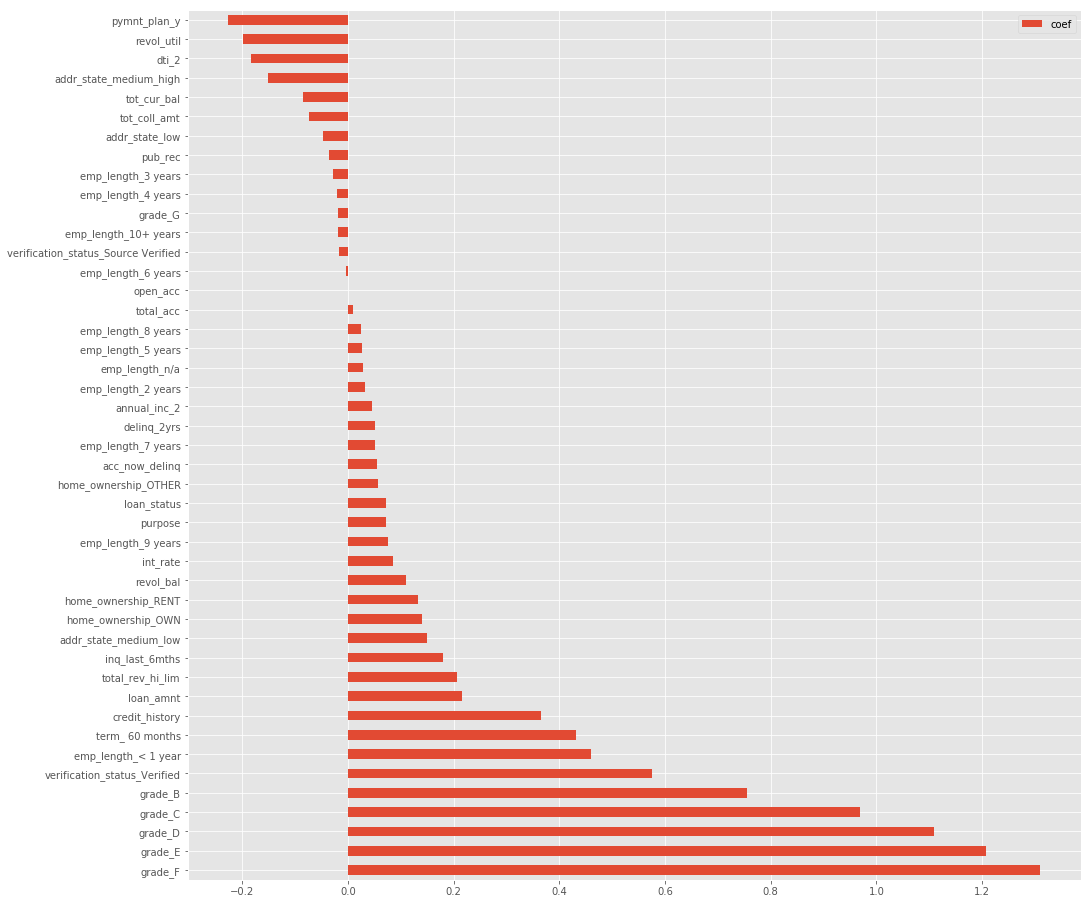

In [242]:
df_coefs = pd.DataFrame(list(zip(df.columns, classifier.coef_.flatten()))).sort_values(by=[1],ascending=False)
df_coefs.columns = ['feature', 'coef']
ax = df_coefs.plot.barh(figsize=(16,16)) 
ax.set_yticklabels(df_coefs['feature'])
plt.show()

### Function for performing train, test, and getting model performance

In [6]:
def train_test_model(clf, X_train, y_train, X_test, y_test):
    # Fit a model by providing X and y from training set
    clf.fit(X_train, y_train)

    # Make prediction on the training data
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]

    # Make predictions on test data
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]

    # print model results
    perf_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc(y_train, p_train_pred, y_test, p_test_pred)

# Random Forest

              train      test
metrics                      
AUC        0.835885  0.713504
Accuracy   0.787235  0.763850
Precision  0.833895  0.588892
Recall     0.157236  0.093928
f1-score   0.264583  0.162015


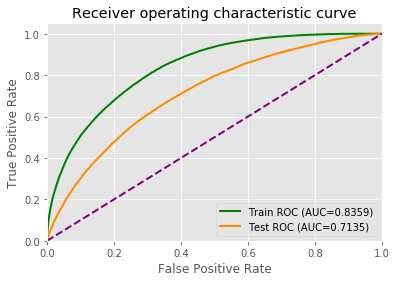

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Try some parameter combinations
parameters = {'n_estimators': 200,
              'max_features': 'auto',
              'criterion': 'gini',
              'max_depth': 30,
              'min_samples_split': 2,
              'min_samples_leaf': 20,
              'random_state': 0,
              'n_jobs': -1
              }

clf = RandomForestClassifier(**parameters)

# Fit a model by providing X and y from training set
clf.fit(X_train, y_train)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

# Gradient Boosting Trees

              train      test
metrics                      
AUC        0.736516  0.715677
Accuracy   0.773044  0.764668
Precision  0.634760  0.563985
Recall     0.159248  0.139803
f1-score   0.254617  0.224064


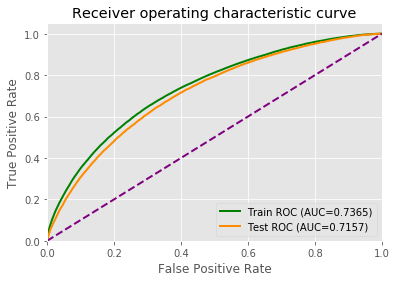

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

# Choose some parameter combinations to try
parameters = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'random_state': 0
}

# parameters = {
#     'n_estimators': 50,
#     'max_depth': 5,
#     'learning_rate': 0.2,
#     'subsample': 0.7,
#     'max_features':0.8,
#     'random_state': 0
# }

clf = GradientBoostingClassifier(**parameters)

clf.fit(X_train, y_train)

train_test_model(clf, X_train, y_train, X_test, y_test)

## Over-sampling with SMOTE

In [14]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['loan_status'])

In [15]:
# Check the numbers
print("length of oversampled data is ",len(os_data_X))
print("Number of good loan in oversampled data",len(os_data_y[os_data_y['loan_status']==0]))
print("Number of bad loan",len(os_data_y[os_data_y['loan_status']==1]))
print("Proportion of good loan data in oversampled data is ",float(len(os_data_y[os_data_y['loan_status']==0]))/len(os_data_X))
print("Proportion of bad loan data in oversampled data is ",float(len(os_data_y[os_data_y['loan_status']==1]))/len(os_data_X))

('length of oversampled data is ', 293552)
('Number of good loan in oversampled data', 146776)
('Number of bad loan', 146776)
('Proportion of good loan data in oversampled data is ', 0.5)
('Proportion of bad loan data in oversampled data is ', 0.5)


In [32]:
from sklearn.ensemble import RandomForestClassifier

# Try some parameter combinations
parameters = {'n_estimators': 300,
              'max_features': 'auto',
              'criterion': 'gini',
              'max_depth': 20,
              'min_samples_split': 2,
              'min_samples_leaf': 60,
              'random_state': 0,
              'n_jobs': -1
              }

clf = RandomForestClassifier(**parameters)

In [36]:
clf.fit(os_data_X, os_data_y)
y_train_pred = clf.predict(os_data_X)
p_train_pred = clf.predict_proba(os_data_X)[:,1]

y_test_pred = clf.predict(X_test)
p_test_pred = clf.predict_proba(X_test)[:,1]


              train      test
metrics                      
AUC        0.897612  0.708026
Accuracy   0.812691  0.726841
Precision  0.832902  0.436876
Recall     0.782335  0.428812
f1-score   0.806827  0.432806


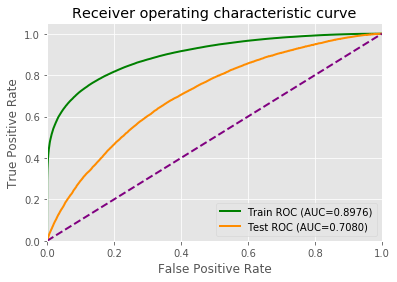

In [39]:
perf_metrics(os_data_y, p_train_pred, y_test, p_test_pred)
plot_roc(os_data_y, p_train_pred, y_test, p_test_pred)

## Retry GDBT

              train      test
metrics                      
AUC        0.905090  0.706488
Accuracy   0.834350  0.757427
Precision  0.910216  0.502021
Recall     0.741879  0.239719
f1-score   0.817471  0.324491


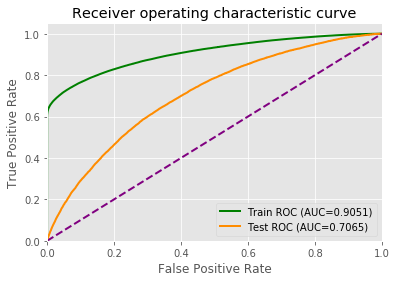

In [31]:
parameters = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'random_state': 0,
    'subsample':0.6,
    'max_features':0.8
}

clf = GradientBoostingClassifier(**parameters)

clf.fit(os_data_X, os_data_y)

train_test_model(clf, os_data_X, os_data_y, X_test, y_test)

## Grid Search and Cross Validation for GDBT

In [21]:
from sklearn.metrics import make_scorer
score = make_scorer(roc_auc_score)

In [25]:
clf = GradientBoostingClassifier()

param_grid = {
    'n_estimators':[100,200],
    'learning_rate':[0.05,0.1],
    'max_depth':[3,5],
    'subsample':[0.63],
    'max_features':[0.8],
    'random_state':[0]
}

grid_obj = GridSearchCV(clf,param_grid,cv=5,scoring=score)
grid_obj = grid_obj.fit(os_data_X, os_data_y)

clf = grid_obj.best_estimator_

KeyboardInterrupt: 

In [ ]:
clf

In [ ]:
clf.fit(os_data_X, os_data_y)
train_test_model(clf, os_data_X, os_data_y, X_test, y_test)

lambdas=np.logspace(-5,5,10)
for c in 1/lambdas:
    logmod=LogisticRegression(penalty='l2',C=c,random_state=0, solver='saga').fit(os_data_X,os_data_y)
    logit_roc_auc = roc_auc_score(y_test, logmod.predict(X_test))
    print 'lambda:',1/c,' AUC:',logit_roc_auc

## Summary

In summary, since there were not too many useful features in the data set, regularization as a method to deal with overfitting and multicollinearity can't improve model performance. However, after up-sampling the data using SMOTE, I was able to improve AUC by 0.11.

Should use more advanced models such as random forest and XGboost in the future, since the decision boundary is highly likely non-linear.

In [270]:
lambdas=np.logspace(-5,5,10)
for c in 1/lambdas:
    logmod=LogisticRegression(penalty='l1',C=c,random_state=0, solver='saga').fit(X_train,y_train)
    logit_roc_auc = roc_auc_score(y_test, logmod.predict(X_test))
    print 'lambda:',1/c,' AUC:',logit_roc_auc

lambda: 1e-05  AUC: 0.543712414054246
lambda: 0.0001291549665014884  AUC: 0.543712414054246
lambda: 0.001668100537200059  AUC: 0.543712414054246
lambda: 0.021544346900318846  AUC: 0.543712414054246
lambda: 0.2782559402207126  AUC: 0.5437618455915668
lambda: 3.5938136638046254  AUC: 0.5437283092729642
lambda: 46.41588833612782  AUC: 0.5433153070186245
lambda: 599.4842503189421  AUC: 0.534225544872069
lambda: 7742.636826811277  AUC: 0.5
lambda: 99999.99999999999  AUC: 0.5
